In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("dependencies")
from music21 import *
from music21.repeat import Expander
from gensim.models import FastText
import numpy as np
import pickle
import matplotlib.pyplot as plt
import librosa

In [25]:
sample_score = converter.parse("data/asap-dataset/Schubert/Impromptu_op.90_D.899/3/xml_score.musicxml") # converter is from the music21 package
# linearized_sample_score = sample_score.expandRepeats() # "Unfolds" repeat measures. Important for visualizing repetitions!
linearized_sample_score = sample_score
# linearized_sample_score.show()

In [4]:
# Cast notes as MIDI note numbers
midi_sequence = []

## STUDENT SECTION - REMOVE ALL OR SOME OF CODE ##
for event in linearized_sample_score.recurse().notes:
    try:
        midi_sequence.append(event.pitch.midi)
    except:
        pass
## END STUDENT SECTION ##


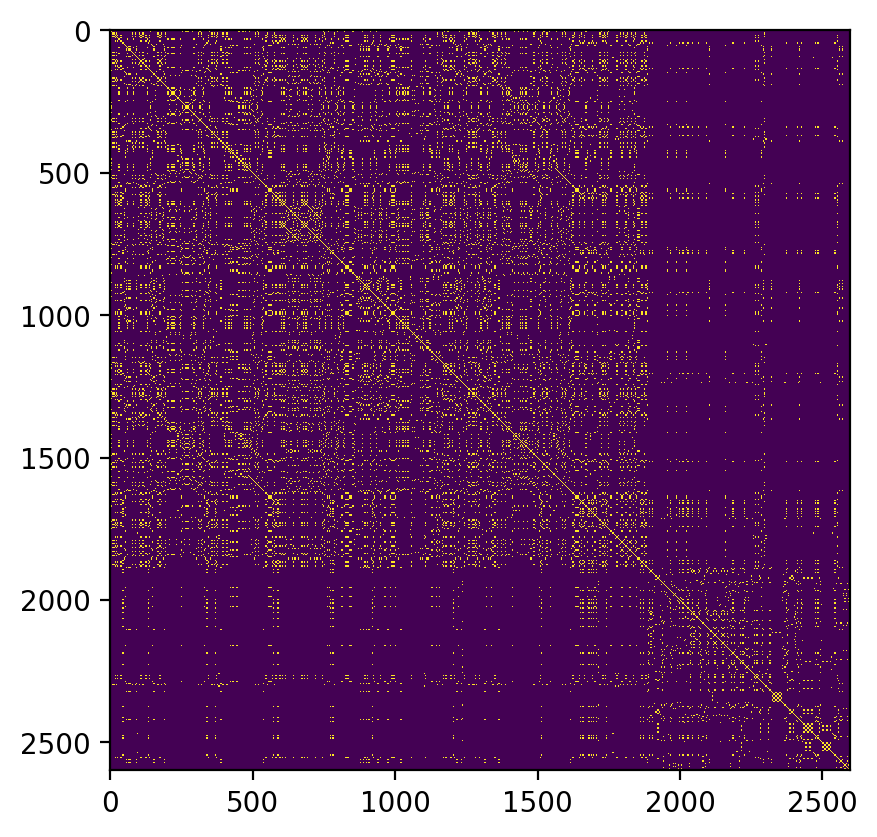

In [5]:

# Kronecker function for upcoming matrix (do not modify)
def kronecker_delta(x, y):
    if x == y:
        return 1
    else:
        return 0

# Create similarity matrix from MIDI note numbers
def calculate_ssm(sequence, similarity_function):
    length = len(sequence)
    ssm = np.zeros((length, length))

    ## STUDENT SECTION - REMOVE ALL OR SOME OF CODE ##
    i = 0
    for element_i in sequence:
        j = 0
        for element_j in sequence:
            ssm[i][j] = similarity_function(element_i, element_j)
            j += 1
        i += 1
    ## END STUDENT SECTION  ##
    
    return ssm

self_sim_mat1 = calculate_ssm(midi_sequence, kronecker_delta)

# Display the SSM - there should be a bright diagonal running f rom the top left to the bottom right
plt.imshow(self_sim_mat1, cmap='viridis', interpolation='nearest')
# plt.xticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
# plt.yticks([4, 14, 18, 28, 32, 42, 46, 56, 69, 93, 117, 135, 148, 172, 196, 214], ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32'], fontsize=8)
plt.show()

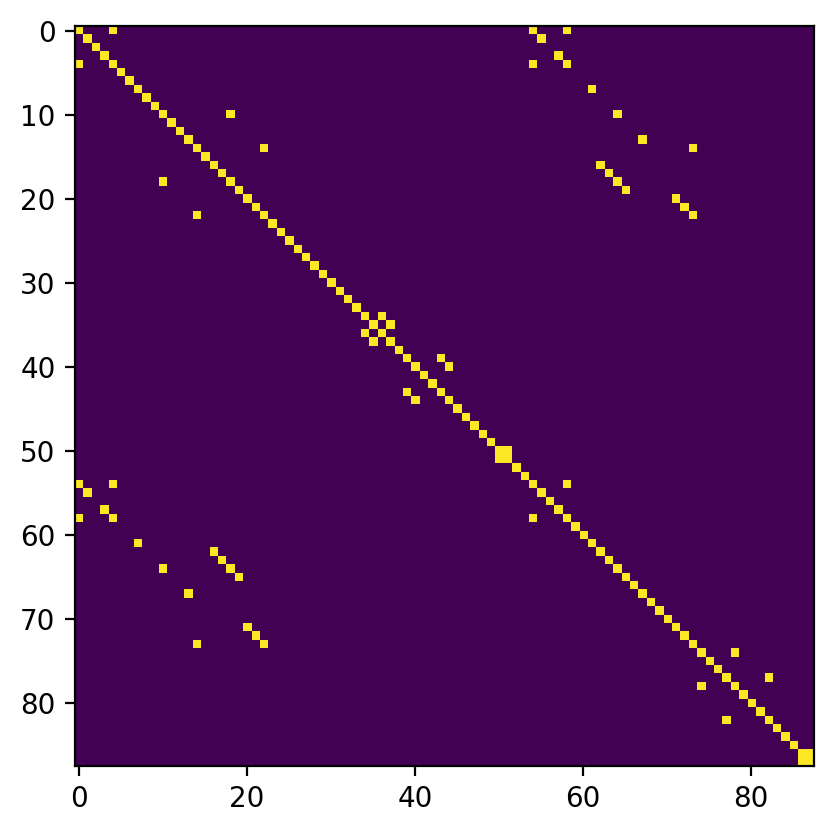

In [6]:
# Cast measures as lists of MIDI note numbers

midi_measure_sequence = []
## STUDENT SECTION - REMOVE ALL OR SOME OF CODE ##
for measure in linearized_sample_score.getElementsByClass(stream.Part)[0].getElementsByClass(stream.Measure):
    measure_midi_list = []
    for event in measure.recurse().notes:
        try:
            measure_midi_list.append(event.pitch.midi)
        except:
            pass
    midi_measure_sequence.append(measure_midi_list)
## END STUDENT SECTION ##

# Create similarity matrix from MIDI measure lists
self_sim_mat2 = calculate_ssm(midi_measure_sequence, kronecker_delta)

plt.imshow(self_sim_mat2, cmap='viridis', interpolation='nearest')
# plt.xticks([0, 4, 8, 12, 16, 20, 24, 28, 32], ['0', '4', '8', '12', '16', '20', '24', '28', '32'], fontsize=8)
# plt.yticks([0, 4, 8, 12, 16, 20, 24, 28, 32], ['0', '4', '8', '12', '16', '20', '24', '28', '32'], fontsize=8)
plt.show()

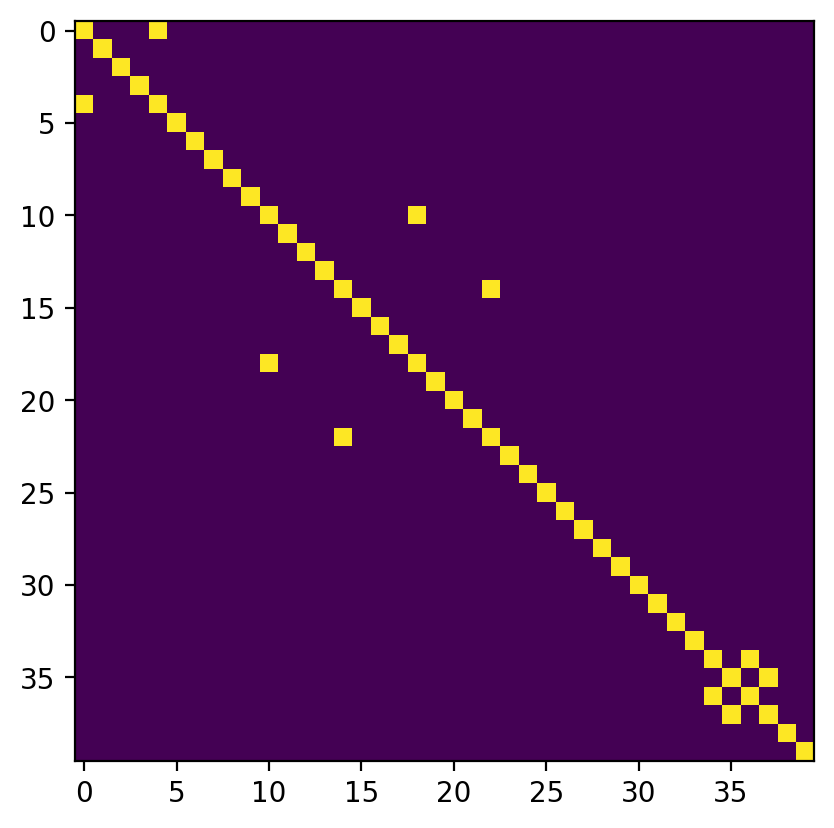

In [17]:
# Slice the matrix to get only the first 40 lines
sliced_self_sim_mat2 = self_sim_mat2[:40,:40]

# Display the sliced matrix
plt.imshow(sliced_self_sim_mat2, cmap='viridis', interpolation='nearest')
plt.show()

/home/bouncer/prg/miniconda3/envs/musicology/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bouncer/prg/miniconda3/envs/musicology/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/bouncer/prg/miniconda3/envs/musicology/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/bouncer/prg/miniconda3/envs/musicology/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/bouncer/prg/miniconda3/envs/musicology/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/bouncer/prg/miniconda3/envs/musicology/lib/python3.10

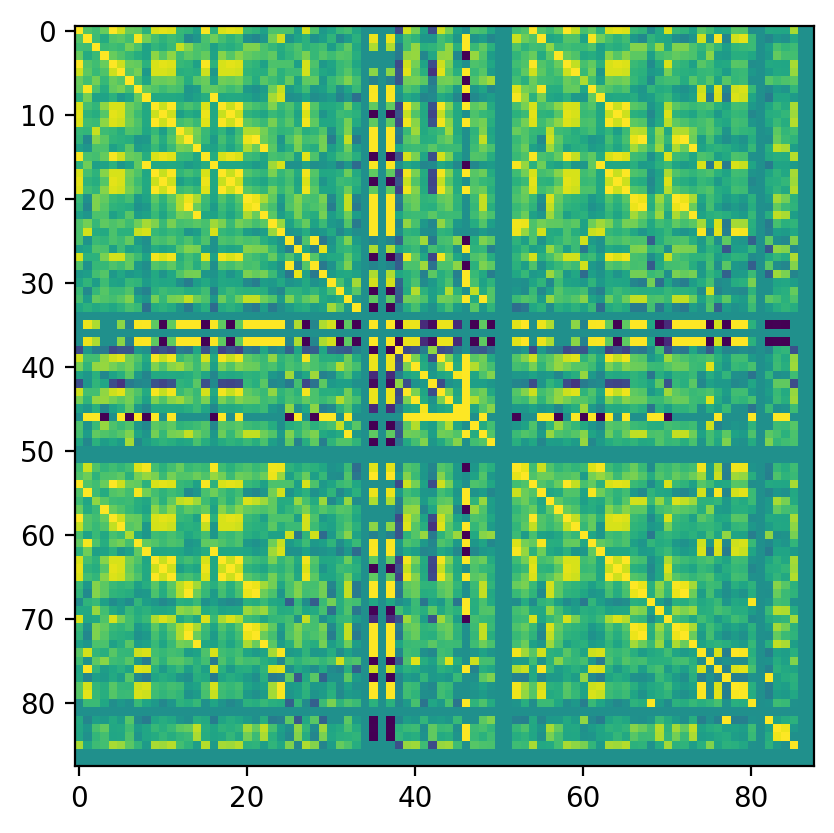

In [19]:
def calculate_correlation(sequence1, sequence2):
    # make sequences same length
    if len(sequence1) > len(sequence2):
        sequence1 = sequence1[:len(sequence2)]
    elif len(sequence2) > len(sequence1):
        sequence2 = sequence2[:len(sequence1)]
    return np.nan_to_num(np.corrcoef(sequence1, sequence2)[0][1])
self_sim_mat2 = calculate_ssm(midi_measure_sequence, calculate_correlation)

plt.imshow(self_sim_mat2, cmap='viridis', interpolation='nearest')
# plt.xticks([0, 4, 8, 12, 16, 20, 24, 28, 32], ['0', '4', '8', '12', '16', '20', '24', '28', '32'], fontsize=8)
# plt.yticks([0, 4, 8, 12, 16, 20, 24, 28, 32], ['0', '4', '8', '12', '16', '20', '24', '28', '32'], fontsize=8)
plt.show()

In [21]:
def compute_kernel_checkerboard_box(L):
    """Compute box-like checkerboard kernel [FMP, Section 4.4.1]

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        L (int): Parameter specifying the kernel size 2*L+1

    Returns:
        kernel (np.ndarray): Kernel matrix of size (2*L+1) x (2*L+1)
    """
    axis = np.arange(-L, L+1)
    kernel = np.outer(np.sign(axis), np.sign(axis))
    return kernel

In [22]:
L = 10
kernel = compute_kernel_checkerboard_box(L)

In [8]:
def compute_kernel_checkerboard_gaussian(L, var=1, normalize=True):
    """Compute Guassian-like checkerboard kernel [FMP, Section 4.4.1].
    See also: https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        L (int): Parameter specifying the kernel size M=2*L+1
        var (float): Variance parameter determing the tapering (epsilon) (Default value = 1.0)
        normalize (bool): Normalize kernel (Default value = True)

    Returns:
        kernel (np.ndarray): Kernel matrix of size M x M
    """
    taper = np.sqrt(1/2) / (L * var)
    axis = np.arange(-L, L+1)
    gaussian1D = np.exp(-taper**2 * (axis**2))
    gaussian2D = np.outer(gaussian1D, gaussian1D)
    kernel_box = np.outer(np.sign(axis), np.sign(axis))
    kernel = kernel_box * gaussian2D
    if normalize:
        kernel = kernel / np.sum(np.abs(kernel))
    return kernel

L = 10
var = 0.5
kernel = compute_kernel_checkerboard_gaussian(L, var)

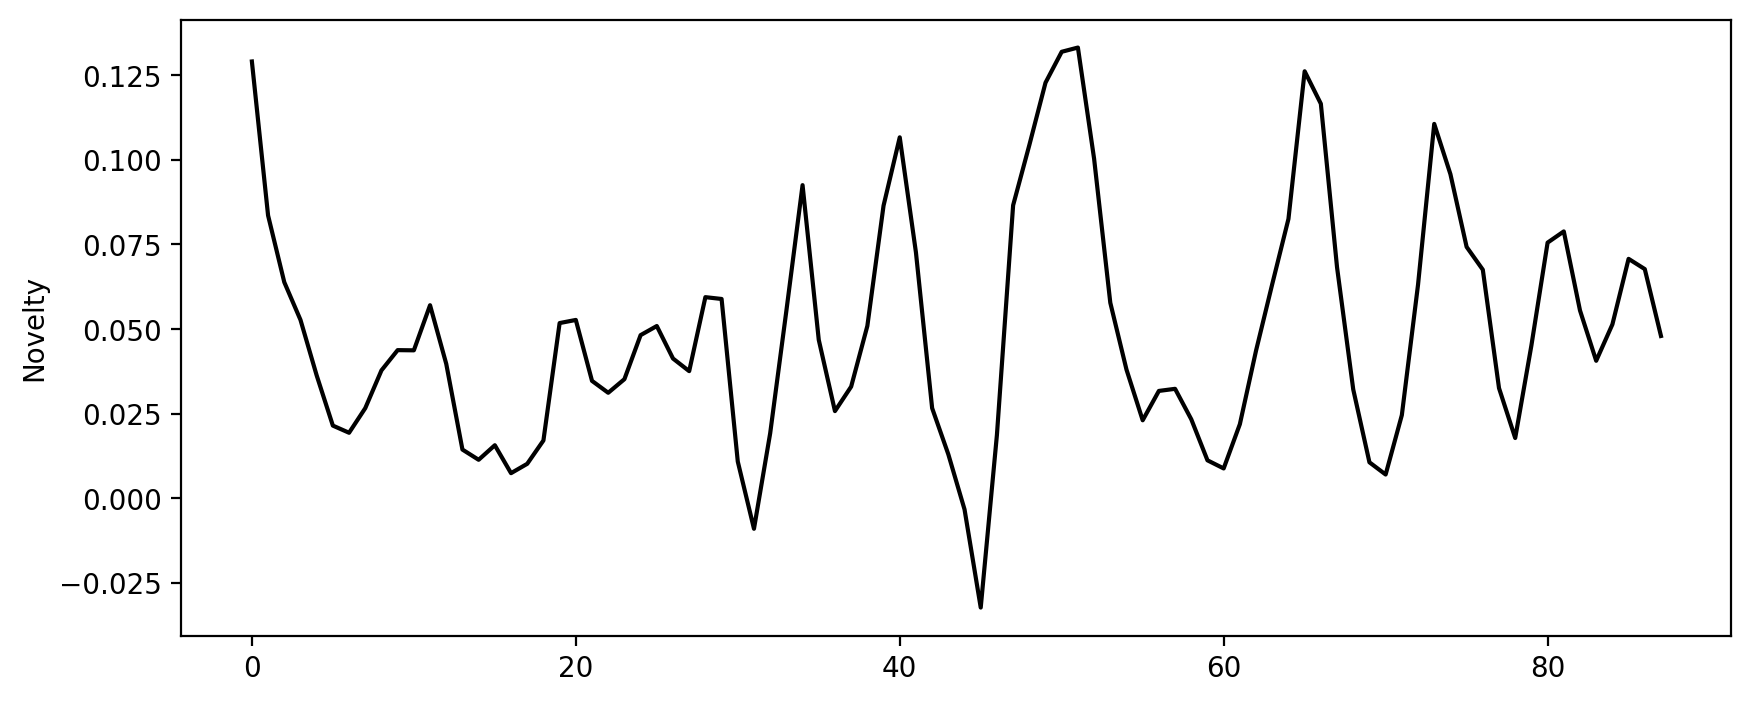

In [24]:
def compute_novelty_ssm(S, kernel=None, L=10, var=0.5, exclude=False):
    """Compute novelty function from SSM [FMP, Section 4.4.1]

    Notebook: C4/C4S4_NoveltySegmentation.ipynb

    Args:
        S (np.ndarray): SSM
        kernel (np.ndarray): Checkerboard kernel (if kernel==None, it will be computed) (Default value = None)
        L (int): Parameter specifying the kernel size M=2*L+1 (Default value = 10)
        var (float): Variance parameter determing the tapering (epsilon) (Default value = 0.5)
        exclude (bool): Sets the first L and last L values of novelty function to zero (Default value = False)

    Returns:
        nov (np.ndarray): Novelty function
    """
    if kernel is None:
        kernel = compute_kernel_checkerboard_gaussian(L=L, var=var)
    N = S.shape[0]
    M = 2*L + 1
    nov = np.zeros(N)
    # np.pad does not work with numba/jit
    S_padded = np.pad(S, L, mode='constant')

    for n in range(N):
        # Does not work with numba/jit
        nov[n] = np.sum(S_padded[n:n+M, n:n+M] * kernel)
    if exclude:
        right = np.min([L, N])
        left = np.max([0, N-L])
        nov[0:right] = 0
        nov[left:N] = 0

    return nov

L_kernel = 10
nov = compute_novelty_ssm(self_sim_mat2, L=L_kernel, exclude=False)   

plt.figure(figsize=(10, 4))
plt.plot(nov, color='k')
plt.ylabel('Novelty')
plt.show() 